# Gaussian Conditional Imputer
Willkommen zu diesem Tutorial über den Gaussian Conditional Imputer!
Hier zeigen wir, wie man **Guassian Conditional Imputer** in Python implementiert und anwendet.

## Inhaltsverzeichnis
1. Was ist ein Gaussian Conditional Imputer?
2. Warum brauchen wir einen Gaussian Conditional Imputer?
3. Wie sieht die Implementierung aus?
4. Test und Visualisierung
5. Grenzen und Verbesserungsmöglichkeiten
6. Fazit

## 1. Was ist ein Gaussian Conditional Imputer?
- Ziel: Fehlende Feature-Werte realistisch ergänzen (= *Imputation*)
- Annahme: Die Daten folgen einer **multivariaten Normalverteilung**
- Grundidee: Wenn ein Teil der Features bekannt ist → andere aus der bedingten Verteilung berechnen
- Formeln: basiert auf Gleichung (10) und (11) aus [Aas et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0004370221000539?via%3Dihub#fm0190), die die **bedingte Erwartung** und die **bedingte Konvarianzmatrix** liefern

## 2. Warum brauchen wir einen Gaussian Conditional Imputer?
* Problem: Viele klassische Methoden (z.B. shap) nehmen Unabhängigkeit zwischen Features an
→ Fehlende Features werden zufällig oder mit Mittelwert ersetzt
* Realität: Features sind oft **korreliert** (z.B. Einkommen und Bildung)  
→ Unabhängigkeitsannahme verzerrt die Shapley-Werte
* Lösung mit Gaussian Conditional Imputer:
        - Nutzt die bedingte multivariate Normalverteilung
        - Sampelt realistische Werte, basierend auf den bekannten Features
        - Führt zu präziseren, konsistenteren Shapley-Werten

## 3. Wie sieht die Implementierung aus?  

In diesem Abschnitt analysieren wir den Code `GaussianImputer`-Klasse Schritt für Schritt. Die Klasse erweitert das Imputer-Interface aus `shapiq` und verwendet die multivariate Normalverteilung, um fehlende Features zu ergänzen.


In [28]:
# Überprüfen der shapiq-Version
!pip install shapiq overrides > /dev/null 2>&1
import shapiq

print(f"shapiq version: {shapiq.__version__}")

shapiq version: 1.2.3



### 3.1 Imports und Überblick
Zuerst importieren wir die benötigten Pakete und bereiten die Klasse `GaussianImputer` vor.

In [29]:
import numpy as np
from scipy.stats import multivariate_normal
from shapiq.games.imputer.base import Imputer

### 3.2 Konstruktur (`__init__`)
Die Klasse erbt von der abstrakten `Imputer`-Klasse im `shapiq`-Framework.  
Die Methode `__init__` initialisiert das Objekt mit Modell, Daten, dem zu erklärenden Punkt `x` und weiteren Parametern.


In [30]:
class GaussianImputer(Imputer):
    def __init__(
        self,
        model: object,
        data: np.ndarray,
        x: np.ndarray | None = None,
        sample_size: int = 100,
        random_state: int | None = None,
        *,
        verbose: bool = False,
    ) -> None:
        super().__init__(
            model,
            data,
            x=x,
            sample_size=sample_size,
            random_state=random_state,
            verbose=verbose,
        )
        self.cond_idx = None
        self.cond_values = None

### 3.3 Fit-Methode  
Diese Methode speichert den Datenpunkt `x`, den wir erklären wollen.  
Dabei werden vorherige Zustände (`cond_idx`, `cond_values`) zurückgesetzt.

In [31]:
    def fit(self, x: np.ndarray) -> GaussianImputer:
        super().fit(x)
        self.cond_idx = None
        self.cond_values = None
        return self

### 3.4 Hauptlogik: `__call__()`  

Diese Methode berechnet für jede gegebene Koalition (Subset von Features) eine erwartete Modellvorhersage. Dabei wird angenommen, dass manche Features (`1`) und andere unbekannt (`0`) sind.

Ablauf:
1. Bekannte Features (`1`) bleiben unverändert
2. Unbekannte Features (`0`) werden mithilfe der bedingten multivariaten Normalverteilung ergänzt
3. Die vervollständigten Datenpuntkte werden dem Modell übergeben
4. Das Modell sagt Vorhersagen für alle Stichproben voraus
5. Der empirische Mittelwert dieser Vorhersagen wird zurückgegeben

-> Damit approximiert diese Methode die Shapley-Funktionsauswertung
$$ v(S) = E[f(x) \mid x_s] $$, welche exakt auf Gleichung (2) aus Aas et al. (2021) basiert.


In [32]:
    def __call__(self, coalitions: np.ndarray) -> np.ndarray:

        results = []

        for coalition in coalitions:
            # 1: Indizes der bekannten (cond_idx) und fehlenden (target_idx) Features ermitteln
            cond_idx = np.where(coalition == 1)[0]
            target_idx = np.setdiff1d(np.arange(self.n_players), cond_idx)

            # Spezialfälle: leere Koalition oder alle Features bekannt
            if len(cond_idx) == 0 or len(target_idx) == 0:
                results.append(self.empty_prediction)
                continue

            # 2: Werte der bekannten Features extrahieren
            cond_values = self.x[0, cond_idx]

            # 3: Bedingte Samples aus der multivariaten Normalverteilung ziehen
            samples, _, _ = self.sample_conditional_gaussian(
                self.data,
                cond_idx,
                cond_values,
                n_samples=self.sample_size,
                random_state=self.random_state,
            )

            # 4: Vorhersage mit dem Modell für alle Samples
            prediction = self.predict(samples)
            mean_pred = np.mean(prediction, axis=0)

            # 5: Mittelwert der Vorhersagen speichern
            results.append(mean_pred)

        # 6: Ergebnisse als Numpy-Array zurückgeben
        return np.array(results)

### 3.5 Der Kern: `sample_conditional_gaussian()`
In dieser Methode wird die zentrale mathematische Idee des Gaussian Imputers umgesetzt. Wir berechnen die bedingte Verteilung der unbekannten Features
$x_{ \bar {S}}$, gegeben die bekannten Features $x_{{S}}$. Ziel ist es, Stichproben für die fehlenden Features zu generieren.

#### ▶ Schritt 1: Erwartungswert und Kovarianz der Gesamtdaten berechnen
Wir gehen davon aus, dass alle Daten aus einer multivariaten Normalverteilung stammen.
Daher berechnen wir:
- den Erwartungswert $ \mu $
- die Kovarianzmatrix $ \Sigma $  

#### ▶ Schritt 2: Aufteilen in bekannte ($S$) und unbekannte ($\bar{S}$) Features
Indizes werden entsprechend getrennt.
Danach teilen wir auch den Erwartungswert $ \mu $ und die Kovarianzmatrix $ \Sigma $ in Teilmatrizen auf:
- $ \mu_S $, $ \mu_{\bar{S}}$
- $ \Sigma_{SS} $, $ \Sigma_{\bar{S}\bar{S}} $, $ \Sigma_{\bar{S}S} $, $ \Sigma_{S\bar{S}} $

#### ▶ Schritt 3: Berechnung der bedingten Verteilung

Die Formeln stammen aus [Aas et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0004370221000539?via%3Dihub#fm0190):
- **Gleichung (10)**: Bedingter Erwartungswert
$$  \mu_{\bar{S} \mid S} = \mu_{\bar{S}} + \Sigma_{\bar{S}S} \Sigma_{SS}^{-1} (x_S^* - \mu_S) $$
- **Gleichung (11)**: Bedingte Kovarianzmatrix
$$  \Sigma_{\bar{S} \mid S} = \Sigma_{\bar{S}\bar{S}} - \Sigma_{\bar{S}S} \Sigma_{SS}^{-1} \Sigma_{S\bar{S}} $$  

Hinweis: Wir verwenden die Pseudoinserse (`np.linalg.pinv`), falls die Matrix nicht invertierbar ist.

#### ▶ Schritt 4: Ziehen von Stichproben

Nun erzeugen wir Stichproben aus
$$ N(\mu_{\bar{S}|S}, \Sigma_{\bar{S}|S})
$$
Diese Samples repräsentieren plausible Werte für die fehlenden Features.

#### ▶ Ergebnis:
- `conditional_samples`: Die gesampelten Werte der fehlenden Features
- `mu_cond`: Der berechnete Erwartungswert der bedingten Verteilung
- `sigma_cond`: Die zugehörige Kovarianzmatrix


In [33]:
def sample_conditional_gaussian(
    data: np.ndarray,
    cond_idx: np.ndarray,
    cond_values: np.ndarray,
    n_samples: int = 1,
    random_state: int | None = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:

    data = np.asanyarray(data)
    cond_values = np.asanyarray(cond_values)

    # 1: Erwartungswert und Kovarianzmatrix
    mu = np.mean(data, axis=0)
    sigma_full = np.cov(data, rowvar=False)

    # 2: Aufteilen in bekannte (S) und unbekannte (S̄) Features
    feature_indices = np.arange(data.shape[1])
    target_idx = np.setdiff1d(feature_indices, cond_idx, assume_unique=True)

    mu_s = np.take(mu, cond_idx)  # μ_S
    mu_sbar = np.take(mu, target_idx)  # μ_{S̄}

    # Teilmatrizen aus der Kovarianzmatrix extrahieren
    sigma_ss = sigma_full[np.ix_(cond_idx, cond_idx)]  # Σ_{SS}
    sigma_sbar_sbar = sigma_full[np.ix_(target_idx, target_idx)]  # Σ_{S̄S̄}
    sigma_sbar_s = sigma_full[np.ix_(target_idx, cond_idx)]  # Σ_{S̄S}
    sigma_s_sbar = sigma_sbar_s.T  # Σ_{SS̄}

    # 3: Berechnung der bedingten Verteilung
    delta = cond_values - mu_s
    inv_sigma_ss = np.linalg.pinv(sigma_ss)
    mu_cond = mu_sbar + sigma_sbar_s @ inv_sigma_ss @ delta
    sigma_cond = sigma_sbar_sbar - sigma_sbar_s @ inv_sigma_ss @ sigma_s_sbar

    # 4: Ziehen von Stichproben aus der bedingten multivariaten Normalverteilung
    conditional_samples = multivariate_normal(
        mean=mu_cond, cov=sigma_cond, allow_singular=True
    ).rvs(size=n_samples, random_state=random_state)

    # Sicherstellen, dass die Ausgabe 2D ist
    if conditional_samples.ndim == 1:
        conditional_samples = conditional_samples.reshape(1, -1)

    return conditional_samples, mu_cond, sigma_cond

## 4. Test und Visualisierung

### 4.1 Test mit künstlichen Testdaten
In diesem Abschnitt testen wir unsere Hauptmethode `sample_conditional_gaussian()` mit künstlich generierten Daten.
- Die multivariate Verteilung hat einen bekannten Erwartungswert und eine Kovarianzmatrix
- Wir fixieren ein Feature und berechnen die bedingte Verteilung der restlichen Features
- Dann vergleichen wir:
  * empirisch berechneten Mittelwert der gesampelten Daten
  * mit dem theoretischen Erwartungswert
- Wenn die beide Werte (und auch die Kovarianzmatrix) gut übereinstimmen, zeigt das, dass unsere Implementierung korrekt ist.


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [35]:
# Dummy-Modell für den Test
def dummy_model(x: np.ndarray) -> np.ndarray:
    return np.sum(x, axis=1)

def test_sample_conditional_gaussian():

    # Testdaten
    rng = np.random.default_rng(0)
    mean = [0, 0, 0]
    cov = [[1, 0.8, 0.5], [0.8, 1, 0.3], [0.5, 0.3, 1]]
    sample_data = rng.multivariate_normal(mean, cov, size=10000)

    # Index und Wert der bekannten Features
    cond_idx = [0]
    cond_values = [0.5]
    n_samples = 10000

    # GaussianImputer mit Dummy-Modell initialisieren
    imputer = GaussianImputer(
        model=dummy_model, data=sample_data, sample_size=n_samples
    )

    # Bedingte Samples erzeugen / Erwartungswert + Kovarianz berechnen
    samples, mu_cond, sigma_cond = sample_conditional_gaussian(
        sample_data, cond_idx, cond_values, n_samples=n_samples, random_state=123
    )

    # Empirische Werte berechnen
    empirical_mean = samples.mean(axis=0)
    empirical_cov = np.cov(samples, rowvar=False)

    # Vergleiche mit den theoretischen Werten
    assert np.allclose(empirical_mean, mu_cond, atol=0.02)
    assert np.allclose(empirical_cov, sigma_cond, atol=0.02)

    print("Bedingte Erwartungswerte:", mu_cond)
    print("Empirischer Mittelwert:", empirical_mean)
    print("-> Differnez:", np.abs(mu_cond - empirical_mean))
    print()

    print("Bedingte Kovarianzmatrix:\n", sigma_cond)
    print("Empirische Kovarianzmatrix\n", empirical_cov)
    print("-> Differenz:\n", np.abs(sigma_cond - empirical_cov))
    print()

    print("Conditional Samples:\n", samples)

test_sample_conditional_gaussian()

Bedingte Erwartungswerte: [0.40247896 0.24290748]
Empirischer Mittelwert: [0.39989483 0.25864618]
-> Differnez: [0.00258413 0.0157387 ]

Bedingte Kovarianzmatrix:
 [[ 0.3634229  -0.08905025]
 [-0.08905025  0.73043497]]
Empirische Kovarianzmatrix
 [[ 0.35570637 -0.07859925]
 [-0.07859925  0.74182342]]
-> Differenz:
 [[0.00771653 0.010451  ]
 [0.010451   0.01138845]]

Conditional Samples:
 [[ 1.1824208  -0.54311823]
 [-0.51215731  0.28431153]
 [ 1.4573317  -0.02911964]
 ...
 [-0.30062915  0.82558158]
 [-0.34799363 -0.15950655]
 [ 0.41051004  1.17349108]]


> **Interpretation**

`Bedingte Erwartungswerte`
- Feature 0 = 0.5 -> erwartete Durchschnittswerte für Feature 1 und 2

`Bedingte Kovarianzmatrix`
- zwischen Feature 1 und 2
- Gültig unter Bedingung: Feature 0 =  0.5
- Zeigt Richtung und Stärke der Abhängigkeit zwischen den verbleibenden Features

`Conditional Samples`
- Gesampelte Werte aus der bedingten Normalverteilung
- Realistische Kombinationen von Feature 1 und 2 bei fixiertem Feature 0

▶ Empirische Werte ≈ Theoretische Werte  
▶ Implementierung korrekt!

### 4.2 Visualisierung

Diese Visualisierung überprüft:
1. Ob die Stichproben wirklich der theoretischen bedingten Verteilung entsprechen
2. In der Praxis wird dies durch numerische Tests überprüft, z.B:
```{python}
assert np.allclose(empirical_mean, mu_cond, atol=0.02)
assert np.allclose(empirical_cov, sigma_cond, atol=0.02)
```

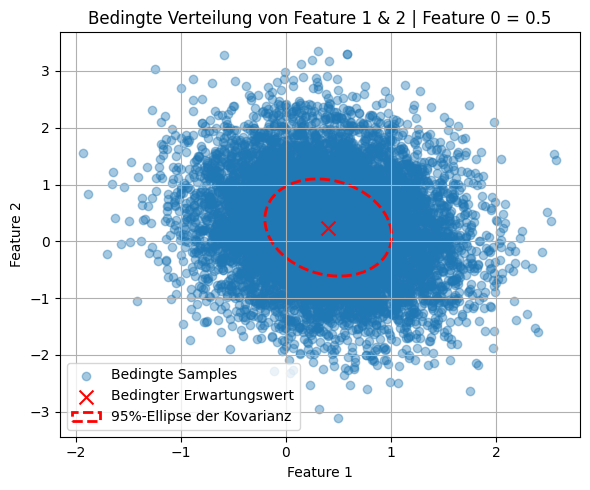

In [37]:
# Testdaten und Stichproben erzeugen
rng = np.random.default_rng(0)
mean = [0, 0, 0]
cov = [[1, 0.8, 0.5], [0.8, 1, 0.3], [0.5, 0.3, 1]]
sample_data = rng.multivariate_normal(mean, cov, size=10000)
cond_idx = [0]
cond_values = [0.5]
n_samples = 10000

samples, mu_cond, sigma_cond = sample_conditional_gaussian(
    sample_data, cond_idx, cond_values, n_samples=n_samples, random_state=123
)

# Datenframe erzeugen
df = pd.DataFrame(samples, columns=["Feature 1", "Feature 2"])

# Stichproben als Streudiagramm
plt.figure(figsize=(6, 5))
plt.scatter(df["Feature 1"], df["Feature 2"], alpha=0.4, label='Bedingte Samples')
plt.scatter(mu_cond[0], mu_cond[1], color='red', label='Bedingter Erwartungswert', marker='x', s=100)

# 95%-Kofidenzellipse aus der bedingten Kovarianz
vals, vecs = np.linalg.eigh(sigma_cond)
order = vals.argsort()[::-1]
vals = vals[order]
vecs = vecs[:, order]
theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
width, height = 2 * np.sqrt(vals)

ellipse = Ellipse(xy=mu_cond, width=width, height=height, angle=theta,
                  edgecolor='red', fc='None', lw=2, linestyle='--',
                  label='95%-Ellipse der Kovarianz')
plt.gca().add_patch(ellipse)

# Achsenbeschriftung, Titel, Legende, Layout
plt.title("Bedingte Verteilung von Feature 1 & 2 | Feature 0 = 0.5")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


> **Interpretation**

`Bedingte Samples`
- Stichproben aus der bedingten Verteilung von Feature 1 und 2
- gegeben Feature 0 = 0.5

`Bedingter Erwartungswert`
- Theoretisch berechneter bedingter Erwartungswert (*mu_cond*)

`95%-Ellipse der Kovarianz`
- 95%-Konfidenzregion, basierend auf der bedingten Kovarianzmatrix (*sigma_cond*)  


◼ Die Stichproben liegen gut innerhalb der Ellipse (basieren auf der Kovarianzstruktur)  
→ Die bedingte Kovarianz wurde unter der Gaußschen Annahme korrekt berücksichtigt.


◼ Die rote Mittelpunkt liegt nahe am Zentrum der Stichprobenverteilung.  
→ Der Imputer hat den bedingten Erwartungswert korrekt geschätzt.

## 5. Grenzen und Verbesserungsmöglichkeiten

Obwohl der Gaussian Conditional Imputer bei der Apporoximation von bedingten Verteilungen nützlich ist, hat er einige wichtige Einschränkungen:

> Starke Annahme der multivariate Normalverteilung

Diese Annahme ist in realen Datensätzen selten erfüllt, insbesondere wenn die Verteilungen schief oder komplex sind.



> Fehlende Flexibilität bei nicht-linearen Abhängigkeiten

Wenn die Abhängigkeiten nicht-linear oder asymmetrisch sind, ist das Modell nicht realistisch.  

Um diese Einschränkungen zu überwinden, schlägt Aas et al. (2021) vor, die Feature-Abhängigkeiten explizit zu modellieren, ohne sich auf Normalverteilung zu verlassen. Die **Gaussian Copula** erlaubt es, die lineare Abhängigkeit beizubehalten, während gleichzeitig beliebige Marginalverteilungen (d.h. Form der einzelnen Features) erlaubt sind.


## 6. Fazit
Der **Gaussian Conditional Imputer** bietet uns ein einfaches und klares Paradigma, um fehlende Werte unter Annahme einer Normalverteilung zu ergänzen. Diese Methode funktioniert gut, wenn die Daten wirklich annährend normalverteilt sind.
In der Praxis sehen wir jedoch oft nicht-lineare Abhängigkeiten oder asymmetrische Verteilungen, die der Gaussian Imputer nicht gut abbilden kann.  

Genau hier bietet der **Gaussian Copula Conditional Imputer** eine wichtige Verbesserung, weil er mehr Flexibilität bei der Modellierung von Abhängigkeiten und Randverteilungen ermöglicht.

